# Ejercicio 2.1: Navegación en Bodega usando Grafos

## Objetivo
Modelar el problema de navegación como un grafo y aplicar algoritmos de búsqueda BFS (Breadth-First Search) y DFS (Depth-First Search).

El robot debe moverse de un punto A a un punto B en la bodega sin chocar, usando la abstracción de la bodega como un grafo.

## Definición del Espacio de Estados
- **Nodos**: Zonas de la bodega ('Start', 'A', 'B', ..., 'Goal')
- **Arcos**: Conexiones transitables entre zonas
- **Estado Inicial**: 'Start'
- **Estado Objetivo**: 'Goal'

In [9]:
# Instalación de librerías necesarias
import networkx as nx
import matplotlib.pyplot as plt
from collections import deque
from typing import List, Dict, Set, Optional, Tuple

## 1. Definición del Mapa de la Bodega

Usamos un diccionario de adyacencias para representar el grafo de la bodega.

In [31]:
# Diccionario de adyacencias - Representa las conexiones entre zonas
warehouse_map = {
    'Start': ['B', 'A'],
    'A': ['Start', 'C', 'D'],
    'B': ['Start', 'D', 'E'],
    'C': ['A', 'Goal'],
    'D': ['A', 'B', 'F'],
    'E': ['B', 'F'],
    'F': ['D', 'E', 'Goal'],
    'Goal': ['C', 'F']
}

print("Mapa de la Bodega:")
print("==================")
for zone, connections in warehouse_map.items():
    print(f"{zone:6} → {connections}")

Mapa de la Bodega:
Start  → ['B', 'A']
A      → ['Start', 'C', 'D']
B      → ['Start', 'D', 'E']
C      → ['A', 'Goal']
D      → ['A', 'B', 'F']
E      → ['B', 'F']
F      → ['D', 'E', 'Goal']
Goal   → ['C', 'F']


## 2. Creación del Grafo con NetworkX

Convertimos el diccionario de adyacencias en un grafo usando NetworkX.

In [32]:
def create_warehouse_graph(adjacency_dict: Dict[str, List[str]]) -> nx.Graph:
    """
    Crea un grafo de NetworkX a partir de un diccionario de adyacencias.

    Args:
        adjacency_dict: Diccionario con nodos y sus conexiones

    Returns:
        Grafo de NetworkX
    """
    G = nx.Graph()

    # Agregar nodos
    for node in adjacency_dict.keys():
        G.add_node(node)

    # Agregar aristas (edges)
    for node, neighbors in adjacency_dict.items():
        for neighbor in neighbors:
            G.add_edge(node, neighbor)

    return G

# Crear el grafo
warehouse_graph = create_warehouse_graph(warehouse_map)

# Información del grafo
print(f"\nGrafo creado:")
print(f"  Nodos: {warehouse_graph.number_of_nodes()}")
print(f"  Aristas: {warehouse_graph.number_of_edges()}")
print(f"  Nodos: {list(warehouse_graph.nodes())}")


Grafo creado:
  Nodos: 8
  Aristas: 10
  Nodos: ['Start', 'A', 'B', 'C', 'D', 'E', 'F', 'Goal']


## 3. Visualización del Grafo

Visualizamos la estructura de la bodega.

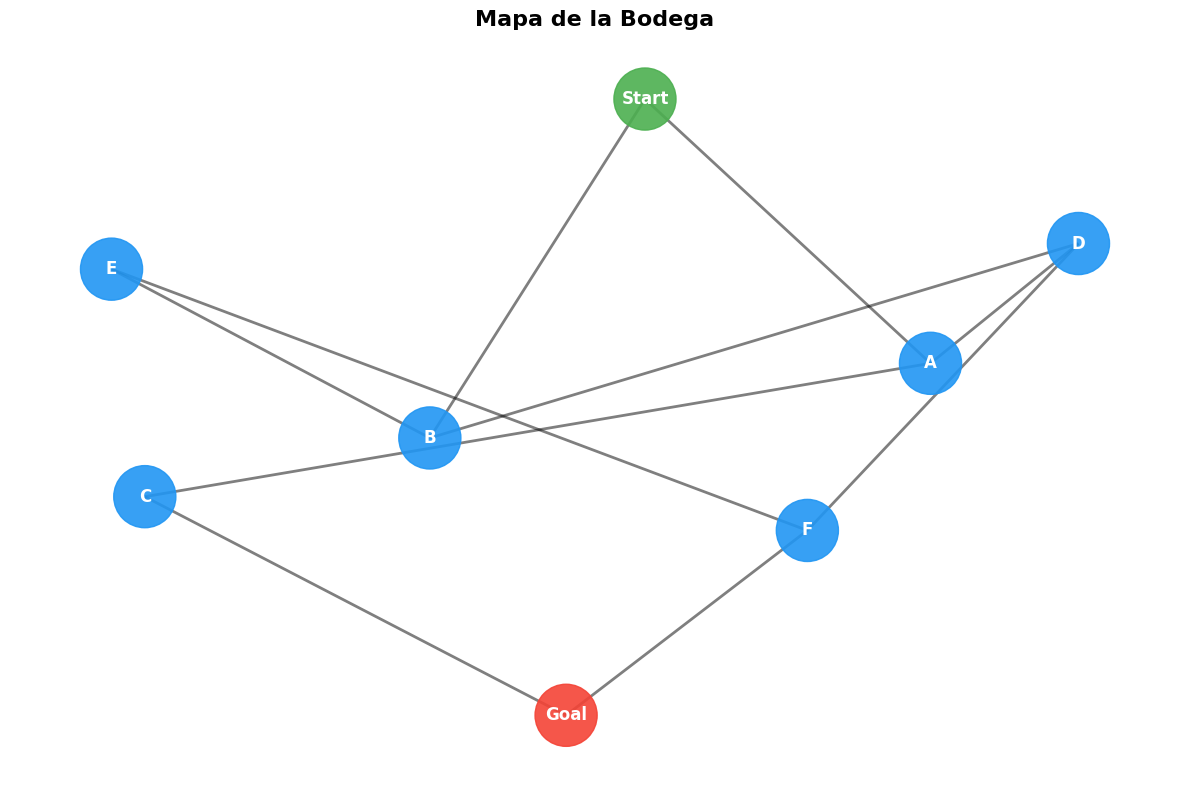

In [34]:
def visualize_warehouse_graph(G: nx.Graph,
                              path: Optional[List[str]] = None,
                              title: str = "Mapa de la Bodega"):
    """
    Visualiza el grafo de la bodega.

    Args:
        G: Grafo de NetworkX
        path: Camino a resaltar (opcional)
        title: Título del gráfico
    """
    plt.figure(figsize=(12, 8))

    # Posicionamiento del grafo usando spring layout
    pos = nx.spring_layout(G, seed=42, k=2)

    # Colores de nodos
    node_colors = []
    for node in G.nodes():
        if node == 'Start':
            node_colors.append('#4CAF50')  # Verde para Start
        elif node == 'Goal':
            node_colors.append('#F44336')  # Rojo para Goal
        elif path and node in path:
            node_colors.append('#FFC107')  # Amarillo para nodos en el camino
        else:
            node_colors.append('#2196F3')  # Azul para nodos normales

    # Dibujar el grafo
    nx.draw_networkx_nodes(G, pos,
                          node_color=node_colors,
                          node_size=2000,
                          alpha=0.9)

    # Dibujar aristas
    if path:
        # Aristas del camino en rojo
        path_edges = [(path[i], path[i+1]) for i in range(len(path)-1)]
        non_path_edges = [e for e in G.edges() if e not in path_edges and (e[1], e[0]) not in path_edges]

        nx.draw_networkx_edges(G, pos,
                              edgelist=non_path_edges,
                              width=2,
                              alpha=0.5,
                              edge_color='gray')

        nx.draw_networkx_edges(G, pos,
                              edgelist=path_edges,
                              width=4,
                              alpha=0.8,
                              edge_color='red',
                              arrows=True,
                              arrowsize=20,
                              arrowstyle='->')
    else:
        nx.draw_networkx_edges(G, pos, width=2, alpha=0.5)

    # Etiquetas
    nx.draw_networkx_labels(G, pos,
                           font_size=12,
                           font_weight='bold',
                           font_color='white')

    plt.title(title, fontsize=16, fontweight='bold')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Visualizar el grafo
visualize_warehouse_graph(warehouse_graph)

## 4. Implementación de BFS (Breadth-First Search)

### Características de BFS:
- Explora nivel por nivel (como ondas en el agua)
- Usa una **cola (Queue)** - FIFO
- **Garantiza el camino más corto** en grafos no ponderados
- Óptimo pero puede usar mucha memoria

In [35]:
def bfs_search(graph: Dict[str, List[str]],
               start: str,
               goal: str,
               verbose: bool = True) -> Tuple[Optional[List[str]], Dict]:
    """
    Búsqueda en Amplitud (BFS) para encontrar un camino de start a goal.

    Args:
        graph: Diccionario de adyacencias
        start: Nodo inicial
        goal: Nodo objetivo
        verbose: Si True, muestra información de la búsqueda

    Returns:
        Tupla con (camino encontrado, estadísticas)
    """
    # Inicialización
    queue = deque([[start]])  # Cola con caminos (cada elemento es una lista)
    visited = set([start])    # Conjunto de nodos visitados
    nodes_explored = 0        # Contador de nodos explorados

    if verbose:
        print("\n" + "="*60)
        print("🔍 BÚSQUEDA EN AMPLITUD (BFS)")
        print("="*60)
        print(f"Inicio: {start} → Objetivo: {goal}")
        print("\nProceso de exploración:")

    # Búsqueda
    while queue:
        # Obtener el primer camino de la cola
        path = queue.popleft()
        current_node = path[-1]
        nodes_explored += 1

        if verbose:
            print(f"  Nivel {len(path)-1} | Explorando: {current_node:6} | Camino actual: {' → '.join(path)}")

        # ¿Llegamos al objetivo?
        if current_node == goal:
            stats = {
                'nodes_explored': nodes_explored,
                'path_length': len(path),
                'nodes_visited': len(visited)
            }

            if verbose:
                print("\n" + "="*60)
                print("✅ ¡OBJETIVO ENCONTRADO!")
                print("="*60)
                print(f"Camino: {' → '.join(path)}")
                print(f"Longitud del camino: {len(path)} nodos")
                print(f"Nodos explorados: {nodes_explored}")
                print(f"Nodos visitados: {len(visited)}")
                print("="*60)

            return path, stats

        # Explorar vecinos
        for neighbor in graph.get(current_node, []):
            if neighbor not in visited:
                visited.add(neighbor)
                new_path = path + [neighbor]
                queue.append(new_path)

    # No se encontró camino
    if verbose:
        print("\n❌ No se encontró un camino al objetivo")

    return None, {'nodes_explored': nodes_explored, 'nodes_visited': len(visited)}

# Ejecutar BFS
bfs_path, bfs_stats = bfs_search(warehouse_map, 'Start', 'Goal', verbose=True)


🔍 BÚSQUEDA EN AMPLITUD (BFS)
Inicio: Start → Objetivo: Goal

Proceso de exploración:
  Nivel 0 | Explorando: Start  | Camino actual: Start
  Nivel 1 | Explorando: B      | Camino actual: Start → B
  Nivel 1 | Explorando: A      | Camino actual: Start → A
  Nivel 2 | Explorando: D      | Camino actual: Start → B → D
  Nivel 2 | Explorando: E      | Camino actual: Start → B → E
  Nivel 2 | Explorando: C      | Camino actual: Start → A → C
  Nivel 3 | Explorando: F      | Camino actual: Start → B → D → F
  Nivel 3 | Explorando: Goal   | Camino actual: Start → A → C → Goal

✅ ¡OBJETIVO ENCONTRADO!
Camino: Start → A → C → Goal
Longitud del camino: 4 nodos
Nodos explorados: 8
Nodos visitados: 8


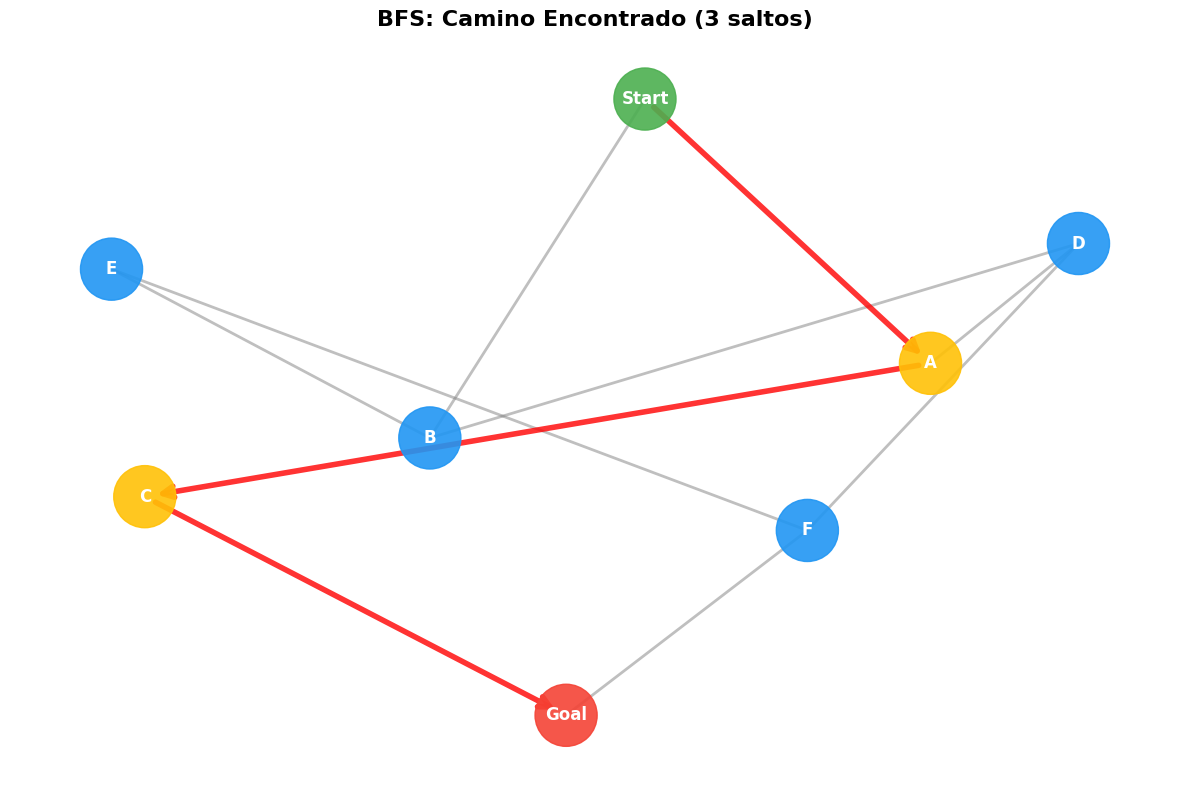

In [36]:
# Visualizar el camino encontrado por BFS
if bfs_path:
    visualize_warehouse_graph(warehouse_graph, bfs_path,
                             title=f"BFS: Camino Encontrado ({len(bfs_path)-1} saltos)")

## 5. Implementación de DFS (Depth-First Search)

### Características de DFS:
- Explora lo más profundo posible antes de retroceder
- Usa una **pila (Stack)** - LIFO
- **NO garantiza el camino más corto**
- Usa menos memoria que BFS
- Útil para exploración exhaustiva

In [37]:
def dfs_search(graph: Dict[str, List[str]],
               start: str,
               goal: str,
               verbose: bool = True) -> Tuple[Optional[List[str]], Dict]:
    """
    Búsqueda en Profundidad (DFS) para encontrar un camino de start a goal.

    Args:
        graph: Diccionario de adyacencias
        start: Nodo inicial
        goal: Nodo objetivo
        verbose: Si True, muestra información de la búsqueda

    Returns:
        Tupla con (camino encontrado, estadísticas)
    """
    # Inicialización
    stack = [[start]]         # Pila con caminos
    visited = set([start])    # Conjunto de nodos visitados
    nodes_explored = 0        # Contador de nodos explorados

    if verbose:
        print("\n" + "="*60)
        print("🔍 BÚSQUEDA EN PROFUNDIDAD (DFS)")
        print("="*60)
        print(f"Inicio: {start} → Objetivo: {goal}")
        print("\nProceso de exploración:")

    # Búsqueda
    while stack:
        # Obtener el último camino de la pila (LIFO)
        path = stack.pop()
        current_node = path[-1]
        nodes_explored += 1

        if verbose:
            print(f"  Profundidad {len(path)-1} | Explorando: {current_node:6} | Camino actual: {' → '.join(path)}")

        # ¿Llegamos al objetivo?
        if current_node == goal:
            stats = {
                'nodes_explored': nodes_explored,
                'path_length': len(path),
                'nodes_visited': len(visited)
            }

            if verbose:
                print("\n" + "="*60)
                print("✅ ¡OBJETIVO ENCONTRADO!")
                print("="*60)
                print(f"Camino: {' → '.join(path)}")
                print(f"Longitud del camino: {len(path)} nodos")
                print(f"Nodos explorados: {nodes_explored}")
                print(f"Nodos visitados: {len(visited)}")
                print("="*60)

            return path, stats

        # Explorar vecinos (en orden inverso para mantener orden original)
        for neighbor in reversed(graph.get(current_node, [])):
            if neighbor not in visited:
                visited.add(neighbor)
                new_path = path + [neighbor]
                stack.append(new_path)

    # No se encontró camino
    if verbose:
        print("\n❌ No se encontró un camino al objetivo")

    return None, {'nodes_explored': nodes_explored, 'nodes_visited': len(visited)}

# Ejecutar DFS
dfs_path, dfs_stats = dfs_search(warehouse_map, 'Start', 'Goal', verbose=True)


🔍 BÚSQUEDA EN PROFUNDIDAD (DFS)
Inicio: Start → Objetivo: Goal

Proceso de exploración:
  Profundidad 0 | Explorando: Start  | Camino actual: Start
  Profundidad 1 | Explorando: B      | Camino actual: Start → B
  Profundidad 2 | Explorando: D      | Camino actual: Start → B → D
  Profundidad 3 | Explorando: F      | Camino actual: Start → B → D → F
  Profundidad 4 | Explorando: Goal   | Camino actual: Start → B → D → F → Goal

✅ ¡OBJETIVO ENCONTRADO!
Camino: Start → B → D → F → Goal
Longitud del camino: 5 nodos
Nodos explorados: 5
Nodos visitados: 7


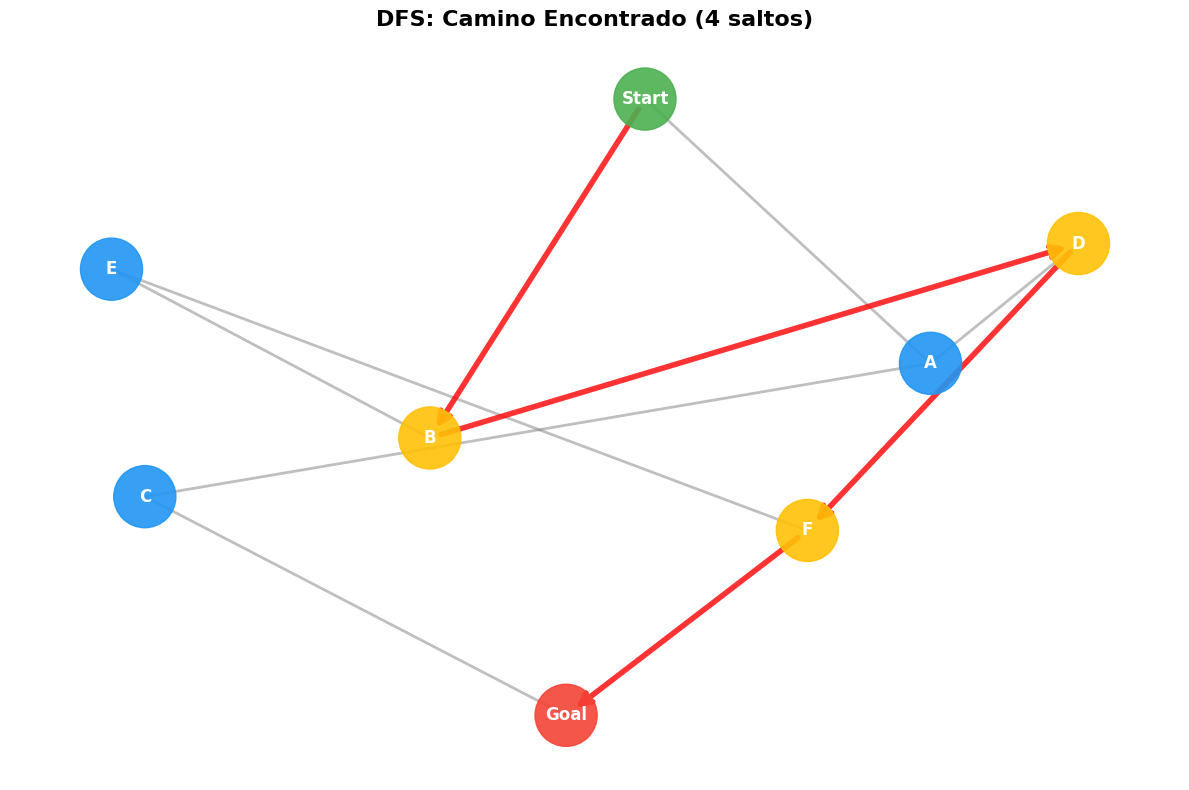

In [38]:
# Visualizar el camino encontrado por DFS
if dfs_path:
    visualize_warehouse_graph(warehouse_graph, dfs_path,
                             title=f"DFS: Camino Encontrado ({len(dfs_path)-1} saltos)")

## 6. Comparación BFS vs DFS

In [39]:
import pandas as pd

# Crear tabla comparativa
comparison_data = {
    'Algoritmo': ['BFS', 'DFS'],
    'Camino': [' → '.join(bfs_path) if bfs_path else 'No encontrado',
               ' → '.join(dfs_path) if dfs_path else 'No encontrado'],
    'Longitud': [bfs_stats['path_length'] if bfs_path else 0,
                 dfs_stats['path_length'] if dfs_path else 0],
    'Nodos Explorados': [bfs_stats['nodes_explored'], dfs_stats['nodes_explored']],
    'Nodos Visitados': [bfs_stats['nodes_visited'], dfs_stats['nodes_visited']],
    'Óptimo': ['✅ Sí', '❌ No garantizado']
}

df_comparison = pd.DataFrame(comparison_data)

print("\n" + "="*100)
print("📊 COMPARACIÓN BFS vs DFS")
print("="*100)
print(df_comparison.to_string(index=False))
print("="*100)


📊 COMPARACIÓN BFS vs DFS
Algoritmo                   Camino  Longitud  Nodos Explorados  Nodos Visitados           Óptimo
      BFS     Start → A → C → Goal         4                 8                8             ✅ Sí
      DFS Start → B → D → F → Goal         5                 5                7 ❌ No garantizado


## 8. Análisis Teórico: BFS vs DFS

### Complejidad Temporal y Espacial

| Aspecto | BFS | DFS |
|---------|-----|-----|
| **Complejidad Temporal** | O(V + E) | O(V + E) |
| **Complejidad Espacial** | O(V) - Peor caso | O(h) - h = altura |
| **Estructura de Datos** | Cola (FIFO) | Pila (LIFO) |
| **Encuentra camino más corto** | ✅ Sí | ❌ No |
| **Uso de Memoria** | Alto | Bajo |
| **Cuando usar** | Objetivo cerca de inicio | Objetivo profundo |

Donde:
- V = número de vértices (nodos)
- E = número de aristas (conexiones)
- h = altura del árbol/grafo

## 10. Conclusiones y Análisis

### ¿Cuándo usar BFS?
- Cuando necesitas **el camino más corto**
- El objetivo está relativamente cerca del inicio
- Tienes suficiente memoria disponible
- Trabajas con grafos no ponderados

### ¿Cuándo usar DFS?
- Cuando la **memoria es limitada**
- El objetivo está en niveles profundos
- No importa si el camino es óptimo
- Necesitas explorar todas las posibilidades (backtracking)

### Observaciones del Ejercicio:
1. **BFS siempre encuentra el camino más corto** en grafos no ponderados
2. **DFS puede encontrar caminos más largos** pero usa menos memoria
3. En bodegas pequeñas, la diferencia puede ser mínima
4. En bodegas grandes, **BFS es preferible** para navegación de robots (camino óptimo)